In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
import torchvision.utils as vutils
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil

In [69]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if str(device) == "cuda":
    print("Using GPU")
else:
    print("Falling back to CPU")

Using GPU


In [70]:
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(degrees=30),  # Randomly rotate the image up to 30 degrees
# #     transforms.RandomCrop(size=(300, 300)),  # Randomly crop a 300x300 section of the image
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly adjust brightness, contrast, and saturation
#     transforms.Resize((128, 128)),  # Resize the image to 350x350
#     transforms.ToTensor(),  # Convert the image to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image according to the ImageNet statistics
# ])


**break**

In [71]:
# Step 1: Select Images
def select_images(source_dir, target_dir, num_images):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    classes = os.listdir(source_dir)

    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        
        if not os.path.exists(target_class_dir):
            os.makedirs(target_class_dir)
        
        images = os.listdir(class_dir)
        selected_images = random.sample(images, min(num_images, len(images)))
        
        for image_name in selected_images:
            source_path = os.path.join(class_dir, image_name)
            target_path = os.path.join(target_class_dir, image_name)
            shutil.copyfile(source_path, target_path)

# Specify source and target directories for image selection
source_train_dir = '/kaggle/input/wildfire-prediction-dataset/train'
source_valid_dir = '/kaggle/input/wildfire-prediction-dataset/valid'
source_test_dir = '/kaggle/input/wildfire-prediction-dataset/test'

target_train_dir = '/kaggle/working/selected_train'
target_valid_dir = '/kaggle/working/selected_valid'
target_test_dir = '/kaggle/working/selected_test'

# Select images for training set
select_images(source_train_dir, target_train_dir, num_images=1000)

# Select images for validation set
select_images(source_valid_dir, target_valid_dir, num_images=300)

# Select images for test set
select_images(source_test_dir, target_test_dir, num_images=300)

# Step 2: Normalize Pixel Values and Step 3: Resize Images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(degrees=30),  # Randomly rotate the image up to 30 degrees
#     transforms.RandomCrop(size=(300, 300)),  # Randomly crop a 300x300 section of the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly adjust brightness, contrast, and saturation
    transforms.Resize((128, 128)),  # Resize the image to 350x350
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image according to the ImageNet statistics
])

# Step 4: Scale Values
train_dataset = datasets.ImageFolder(root=target_train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = datasets.ImageFolder(root=target_valid_dir, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = datasets.ImageFolder(root=target_test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now, train_loader, valid_loader, and test_loader contain the selected, normalized, and resized images.


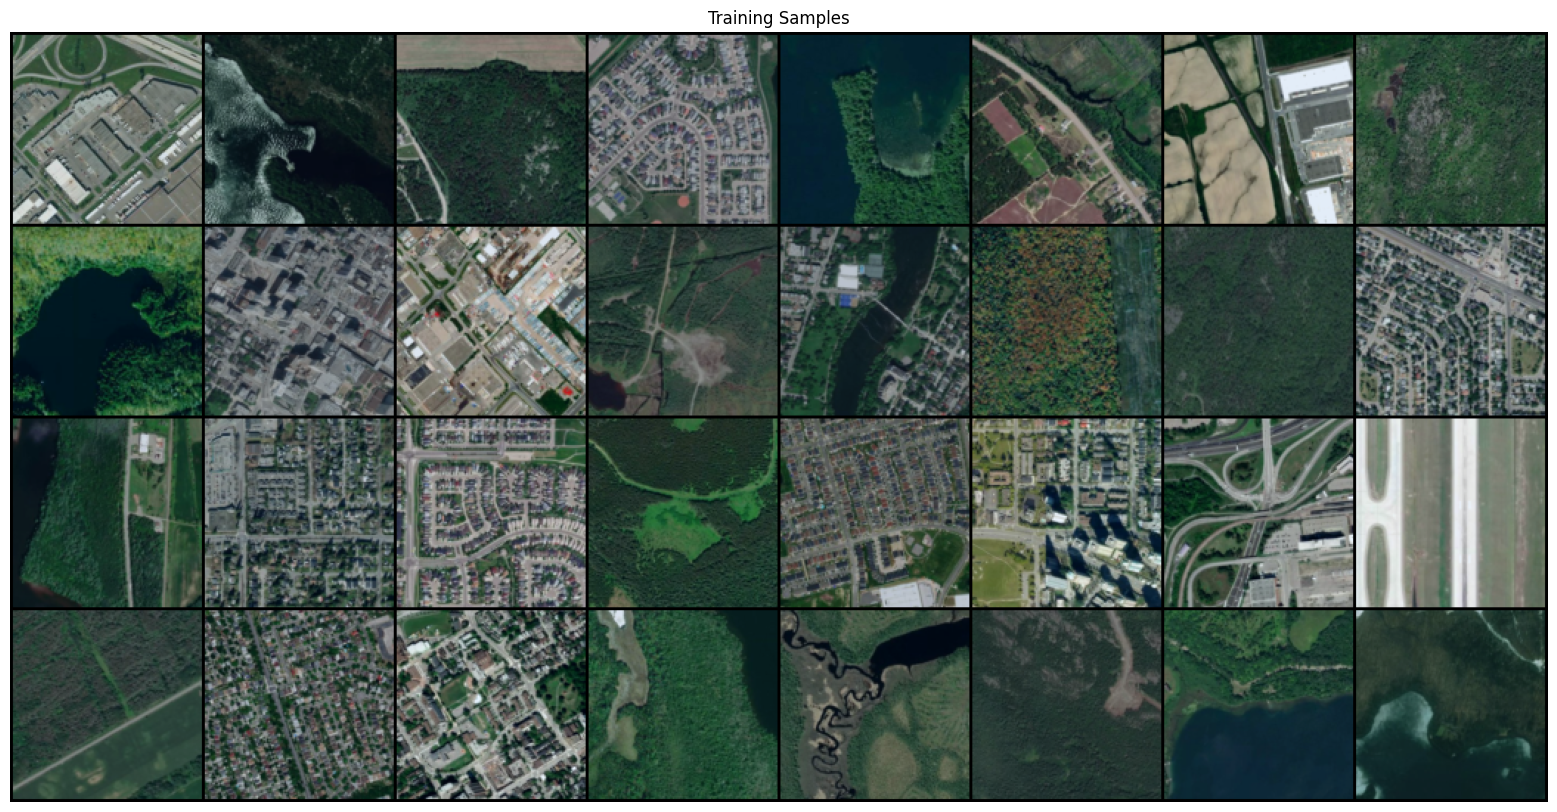

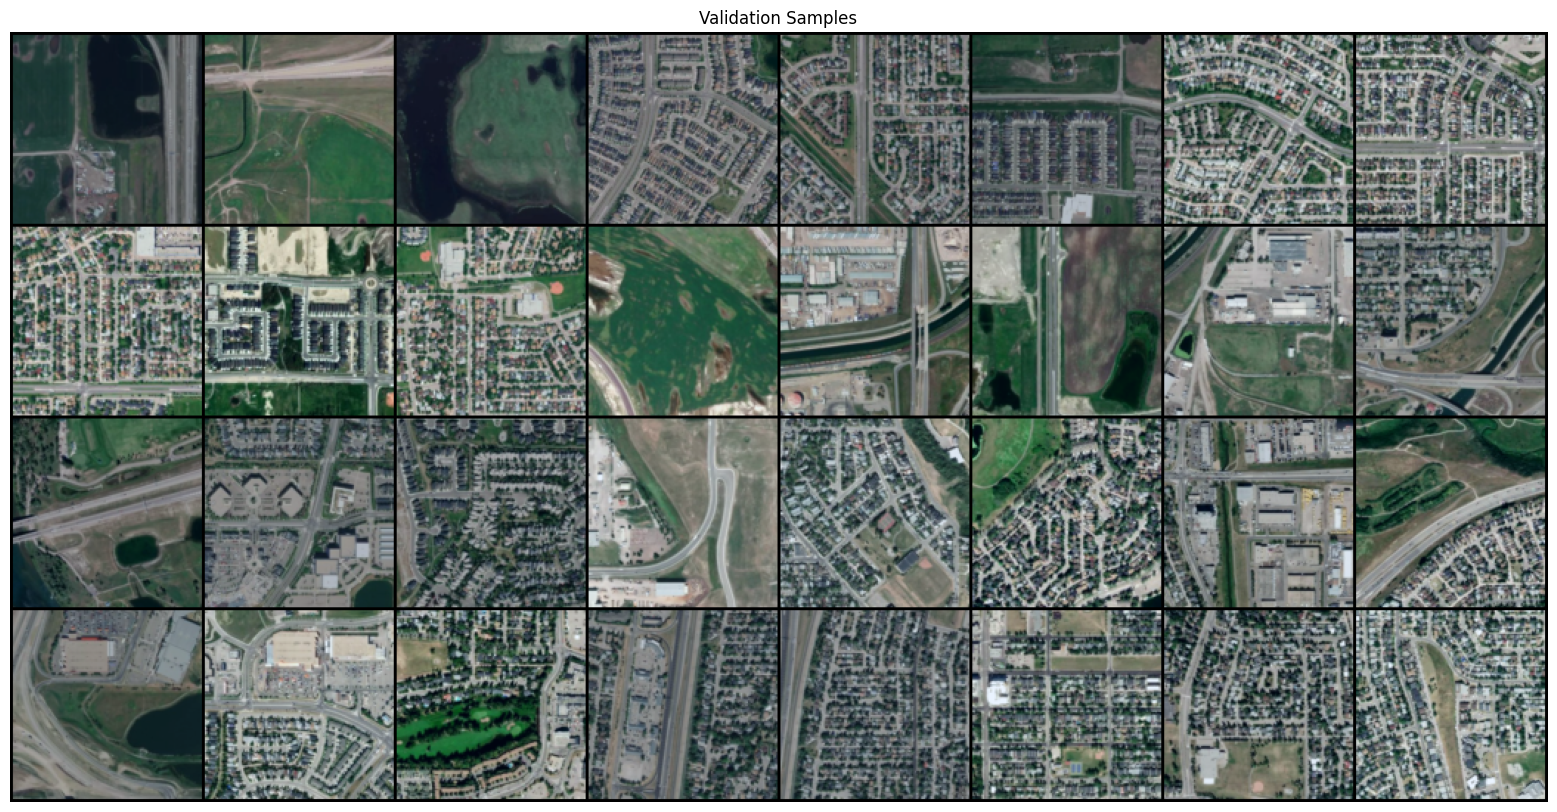

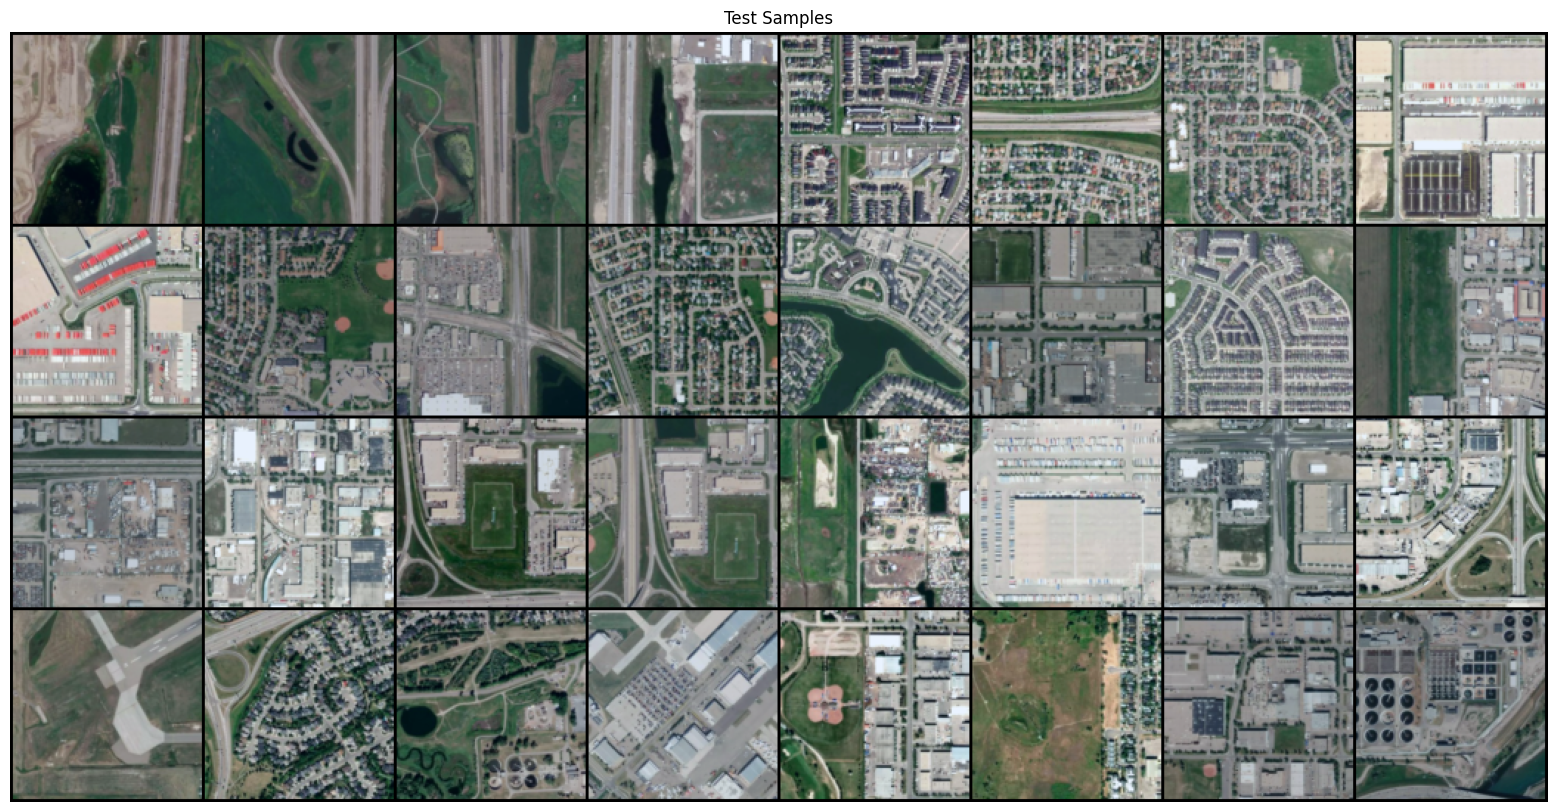

In [72]:

# Function to display sample images from a DataLoader
def show_samples(loader, title):
    # Get a batch of images from the loader
    images, labels = next(iter(loader))
    # Create a grid of images
    grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)
    # Convert tensor to numpy array and transpose channels
    grid = grid.permute(1, 2, 0)
    # Display the grid of images
    plt.figure(figsize=(20, 10))
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display sample images from training, validation, and test sets
show_samples(train_loader, title='Training Samples')
show_samples(valid_loader, title='Validation Samples')
show_samples(test_loader, title='Test Samples')


In [73]:
# Function to count the number of images in each class for a given directory
def count_images_per_class(directory):
    classes = os.listdir(directory)
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
    return class_counts

# Define directories for training, validation, and test sets
train_dir = '/kaggle/working/selected_train'
valid_dir = '/kaggle/working/selected_valid'
test_dir = '/kaggle/working/selected_test'

# Count the number of images in each class for each set
train_counts = count_images_per_class(train_dir)
valid_counts = count_images_per_class(valid_dir)
test_counts = count_images_per_class(test_dir)

# Display the counts
print("Training set:")
print(train_counts)
print("Validation set:")
print(valid_counts)
print("Test set:")
print(test_counts)


Training set:
{'nowildfire': 1000, 'wildfire': 1000}
Validation set:
{'nowildfire': 300, 'wildfire': 300}
Test set:
{'nowildfire': 300, 'wildfire': 300}


In [74]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, num_classes)
        
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)
        
        self.dropout = nn.Dropout(p=0.5)  # Optional dropout layer
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Optional dropout
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Optional dropout
        
        x = self.fc_out(x)
        return torch.sigmoid(x)  # Sigmoid activation for binary classification


In [75]:
# Create an instance of the CNN model for binary classification
model = CNNModel(num_classes=1).to(device)
# Print the model architecture
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=1, bias=True)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [76]:
!pip install torchsummary

from torchsummary import summary
input_size = (3, 128, 128)

summary(model, input_size)

# Assuming your input images have size 128x128 and 3 channels (RGB)

# Pass your model and input_size to the summary function


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
      BatchNorm2d-14          [-1, 256,

In [77]:
# Function to train the model for one epoch
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels.float().view(-1, 1)).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


In [78]:
# Function to evaluate the model on the validation set
def evaluate_model(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels.float().view(-1, 1)).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy, all_preds, all_labels


In [79]:
# Function to evaluate the model on the test set
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels


In [80]:

def plot_confusion_matrix(conf_matrix, target_names):
    plt.figure(figsize=(7, 5))
    plt.imshow(conf_matrix, interpolation='nearest', cmap='Spectral')
    plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    plt.ylabel('Actual Labels', fontweight='bold', fontsize=13)
    plt.xlabel('Predictioned Labels', fontweight='bold', fontsize=13)

    for i in range(len(target_names)):
        for j in range(len(target_names)):
            plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='white')

    plt.tight_layout()
    plt.show()


Epoch 1/10, Train Loss: 0.5994, Train Acc: 0.8425, Valid Loss: 0.3973, Valid Acc: 0.8833
Epoch 2/10, Train Loss: 0.3884, Train Acc: 0.8835, Valid Loss: 0.2714, Valid Acc: 0.9083
Epoch 3/10, Train Loss: 0.3061, Train Acc: 0.9000, Valid Loss: 0.2456, Valid Acc: 0.9183
Epoch 4/10, Train Loss: 0.2724, Train Acc: 0.9075, Valid Loss: 0.2421, Valid Acc: 0.9217
Epoch 5/10, Train Loss: 0.2241, Train Acc: 0.9190, Valid Loss: 0.1864, Valid Acc: 0.9133
Epoch 6/10, Train Loss: 0.2217, Train Acc: 0.9200, Valid Loss: 0.1922, Valid Acc: 0.9217
Epoch 7/10, Train Loss: 0.2186, Train Acc: 0.9145, Valid Loss: 0.2077, Valid Acc: 0.9250
Epoch 8/10, Train Loss: 0.2144, Train Acc: 0.9295, Valid Loss: 0.3615, Valid Acc: 0.8617
Epoch 9/10, Train Loss: 0.2005, Train Acc: 0.9260, Valid Loss: 0.5340, Valid Acc: 0.8183
Epoch 10/10, Train Loss: 0.2137, Train Acc: 0.9205, Valid Loss: 0.2283, Valid Acc: 0.8950
Test Accuracy: 0.9217


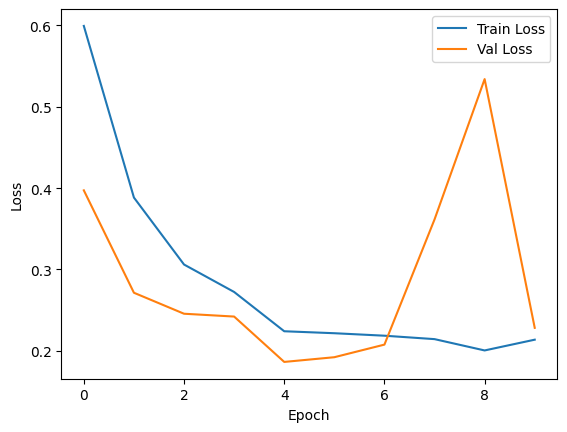

Confusion Matrix:


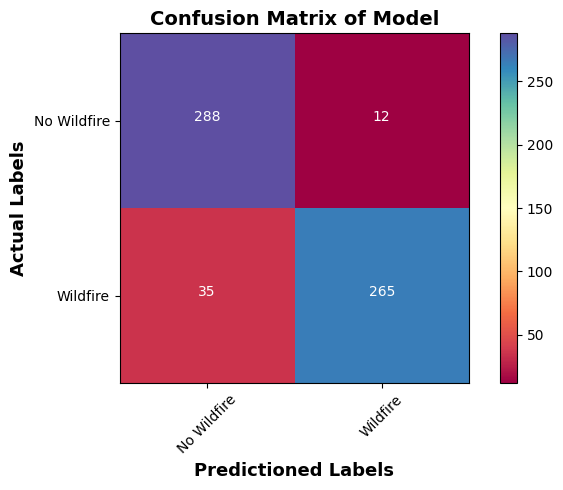


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       300
           1       0.96      0.88      0.92       300

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



In [81]:
# Define your model, optimizer, loss function, and data loaders

# Train and validate the model
criterion = nn.BCELoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    # Training phase
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    valid_loss, valid_accuracy, _, _ = evaluate_model(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

# Evaluate the trained model on the test set
test_preds, test_labels = test_model(model, test_loader, device)

# Calculate test accuracy
correct = sum(1 for pred, label in zip(test_preds, test_labels) if pred == label)
test_accuracy = correct / len(test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the training and validation curves
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds)

print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, target_names=['No Wildfire', 'Wildfire'])
print("\nClassification Report:")
print(class_report)


ooga


In [82]:


# what is overfiting and underfitting

In [83]:

# Replace conf_arr with your confusion matrix variable and target_names with your class names



ValueError: 'rocket' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'